<a href="https://colab.research.google.com/github/RDelg/rl-book/blob/master/chapter5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from collections import OrderedDict

import numpy as np
from numpy import random

In [2]:
class BoundedArraySpec:
    def __init__(self, shape, dtype, minimum, maximum):
        self.shape = shape
        self.dtype = dtype
        self.minimum = minimum
        self.maximum = maximum

In [3]:
class Trajectory:
    class Step:
        def __init__(self, is_final, state, action, reward):
            self.is_final = is_final
            self.state = state
            self.action = action
            self.reward = reward

    def __init__(self):
        self.steps = []

    def add_step(self, is_final, state, action, reward):
        self.steps.append(Trajectory.Step(is_final, state, action, reward))
    
    def __len__(self):
        return len(self.steps)

    def __getitem__(self, index):
        return self.steps[index]

In [4]:
class BlackJack():
    
    _CARDS = OrderedDict({
        '_1': 1,
        '_2': 2,
        '_3': 3,
        '_4': 4,
        '_5': 5,
        '_6': 6,
        '_7': 7,
        '_8': 8,
        '_9': 9,
        '_J': 10,
        '_Q': 10,
        '_K': 10,
        '_A': 1
    })

    def action_spec(self):
        return BoundedArraySpec((1,), np.int32, minimum=[0], maximum=[1])

    def observation_spec(self):
        return BoundedArraySpec([3,], np.int32, minimum=[12, 0, 0], maximum=[21, 1, 12])

    @staticmethod
    def get_card():
        return random.choice(list(BlackJack._CARDS.keys()))
    
    def __init__(self):
        self.reset()
    
    def reset(self):
        # Dealer
        self.dealer_card =  self.get_card()
        self._dealer_usable_ace = self.dealer_card == '_A'
        # Player
        self.player_sum = 0
        self.usable_ace = False
        self.player_sum, self.usable_ace = self.hit(self.player_sum, self.usable_ace)
    
    @property
    def state(self):
        return (self.player_sum, self.usable_ace, list(self._CARDS.keys()).index(self.dealer_card))

    @staticmethod
    def hit(current_sum: int, usable_ace: bool):
        card = BlackJack.get_card()
        if card == '_A' and current_sum < 11:
            current_sum += 11
            usable_ace = True
        else:
            current_sum += BlackJack._CARDS[card]
            if current_sum > 21 and usable_ace:
                current_sum -= 10
                usable_ace = False
        if current_sum < 12:
            return BlackJack.hit(current_sum, usable_ace)
        else:
            return current_sum, usable_ace
    
    def stick(self):
        dealer_sum = 11 if self._dealer_usable_ace else BlackJack._CARDS[self.dealer_card]
        while dealer_sum < 17:
            dealer_sum, self._dealer_usable_ace =  self.hit(dealer_sum, self._dealer_usable_ace)
        return dealer_sum

    @staticmethod
    def _rules(sum):
        if sum > 21:
            return -1 # Bust
        else:
            return 0 # Nothing happens

    def step(self, action: int):
        """Performs an action and returns the enviroment response.
            Posible action values:
                - 0: Hit
                - 1: Stick
            The return value is a tuple where each position is:
                - [0]: A boolean indicating if the game has ended
                - [1]: The reward obtained
                - [2]: The new state of the game
        """
        if action == 0:
            self.player_sum, self.usable_ace = self.hit(self.player_sum, self.usable_ace)
            if self._rules(self.player_sum) == -1:
                return True, -1, None
            else:
                return False, 0, self.state
        elif action == 1:
            dealer_sum = self.stick()
            if self._rules(dealer_sum) == -1:
                return True, 1, None
            elif dealer_sum == self.player_sum:
                return True, 0, None
            elif dealer_sum < self.player_sum:
                return True, 1, None
            else:
                return True, 0, None
        else:
            raise Exception(f'Invalid action: {action}')

In [5]:
class MonteCarloPredictor():
    def __init__(self, env):
        self.env = env
        self.create_value_function(env.observation_spec())
        self.n = np.zeros_like(self.state_value, dtype=np.int32)

    def create_value_function(self, obs_space):
        assert len(obs_space.shape) == 1, 'Observation space must be 1 dimensional'
        shape = [_max - _min + 1 for _max, _min in zip(obs_space.maximum, obs_space.minimum)]
        self.state_value = np.zeros(shape=shape, dtype=np.float32)
        self._min_obs_space = obs_space.minimum
    
    def _state_to_index(self, state):
        return tuple(state[i] - self._min_obs_space[i] for i in range(len(self.n.shape)))

    @staticmethod
    def generate_episode(env, policy):
        trajectory = Trajectory()
        env.reset()
        state = env.state
        finished = False
        reward = 0
        while not finished:
            action = policy(state)
            trajectory.add_step(finished, state, action, reward)
            finished, reward, new_state = env.step(action)
            state = new_state
        trajectory.add_step(finished, state, action, reward)
        return trajectory

    def predict(self, policy, n=1):
        for _ in range(n):
            trajectory = self.generate_episode(self.env, policy)
            g = 0
            for i in range(len(trajectory)-1, 0, -1):
                g += trajectory[i].reward
                previous_states = set(x.state for x in trajectory[0:i-1])
                if trajectory[i-1].state not in previous_states:
                    index = self._state_to_index(trajectory[i-1].state)
                    self.n[index] += 1
                    self.state_value[index] += (g - self.state_value[index]) / self.n[index]

In [6]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

def plot_value(value, ax=None, title='Value', figsize=(6,6)):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')
    
    x_range = value.shape[1]
    y_range = value.shape[0]
    X, Y = np.meshgrid(np.arange(x_range), np.arange(y_range))
    ax.plot_surface(X, Y, value, cmap=cm.coolwarm)

    ax.set_xticks(np.arange(x_range))
    ax.set_yticks(np.arange(y_range))
    ax.set_xlabel('Dealer showing')
    ax.set_ylabel('Player sum')

    ax.set_xticklabels([x.replace('_', '') for x in BlackJack._CARDS.keys()]);
    ax.set_yticklabels(np.arange(y_range) + 11);
    
    ax.set_title(title)

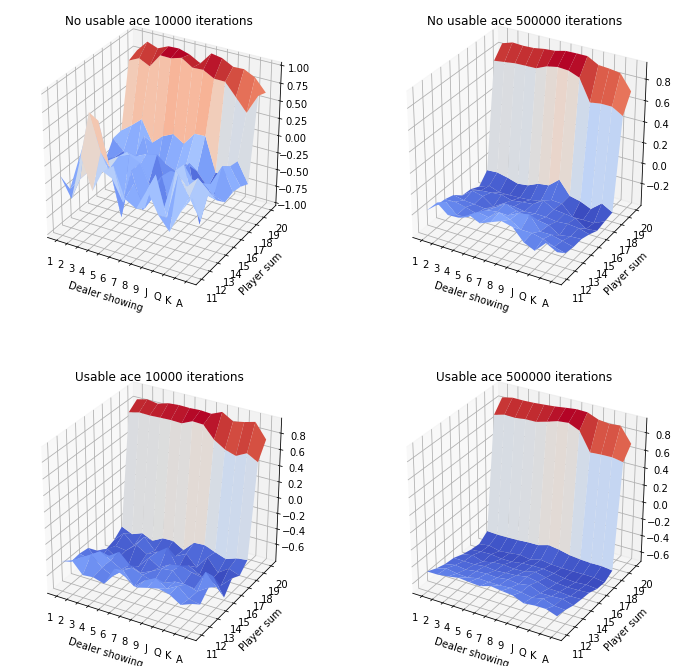

In [7]:
def figure_5_1(figsize=(12,12)):
    fig = plt.figure(figsize=figsize)
    env = BlackJack()
    policy = lambda state: state[0] >= 20
    for i, iter in enumerate([10000, 500000]):
        mc = MonteCarloPredictor(env)
        mc.predict(policy, n=iter)
        plot_value(mc.state_value[:,1,:], fig.add_subplot(2,2,1+i,projection='3d'), f'No usable ace {iter} iterations')
        plot_value(mc.state_value[:,0,:], fig.add_subplot(2,2,3+i,projection='3d'), f'Usable ace {iter} iterations')
    
figure_5_1()